In [4]:
import re
import json
import numpy
import folium
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, linestring
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import set_matplotlib_formats
import seaborn as sns
import googlemaps

# 그래프에서 마이너스 폰트 깨짐에 대한 대터
plt.rc('axes', unicode_minus=False)
# 한글폰트 설정
plt.rc('font', family='Malgun Gothic')
# 폰트 선명히 보이기 위해서
set_matplotlib_formats('retina')
plt.style.use('ggplot')

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# 1. 데이터 EDA 및 전처리

## 1.1 인구 격자 정보

In [5]:
# 강서구 인구 격자 정보
# 좌표 체계 GRS80 UTMK
gangseo_pop_grid=gpd.read_file('data/gangseogrid/nlsp_021001001.shp', encoding='utf-8')
gangseo_pop_grid.head()

,gid,lbl,val,geometry
0,다사404502,289.00,289.0,"POLYGON ((940400.000 1950200.000, 940400.000 1..."
1,다사436483,217.00,217.0,"POLYGON ((943600.000 1948300.000, 943600.000 1..."
2,다사391528,46.00,46.0,"POLYGON ((939100.000 1952800.000, 939100.000 1..."
3,다사400518,615.00,615.0,"POLYGON ((940000.000 1951800.000, 940000.000 1..."
4,다사402503,646.00,646.0,"POLYGON ((940200.000 1950300.000, 940200.000 1..."


In [6]:
# .crs를 통해서 shp 파일 정보 확인
gangseo_pop_grid.crs

<Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
gangseo_pop_grid['lbl'].value_counts()

N/A       76
6.00      10
461.00     8
545.00     7
255.00     7
          ..
196.00     1
675.00     1
338.00     1
433.00     1
703.00     1
Name: lbl, Length: 707, dtype: int64

In [9]:
# gangseo_pop_grid의 결측치 값 확인
gangseo_pop_grid.isna().sum()

gid            0
lbl         2792
val         2792
geometry       0
dtype: int64

In [8]:
# gangseo_pop_grid의 lbl, val 컬럼이 동일한 것을 확인한다.
gangseo_pop_grid.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       4382 non-null   object  
 1   lbl       1590 non-null   object  
 2   val       1590 non-null   float64 
 3   geometry  4382 non-null   geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 137.1+ KB


In [10]:
# lbl 컬럼의 'N/A' 문자열을 문자 0으로 변환
# NA 값을 0으로 전체 변환 
# int형으로 형변환 맞춰주기 
gangseo_pop_grid['lbl']=gangseo_pop_grid['lbl'].str.replace('N/A', '0')
gangseo_pop_grid.fillna(0, inplace=True)
gangseo_pop_grid=gangseo_pop_grid.astype({'lbl':'float'})
gangseo_pop_grid=gangseo_pop_grid.astype({'lbl':'int', 'val':'int'})

In [11]:
# lbl과 val이 똑같은 값으로 확인한다. 
gangseo_pop_grid[(gangseo_pop_grid['lbl'] == gangseo_pop_grid['val']) == False]

,gid,lbl,val,geometry


In [ ]:
# 저장하기
gangseo_pop_grid.to_csv('gangseo_pop_grid.csv', encoding='cp949')

## 1.2 상권정보

In [39]:
# 상권정보에 대해서 강서구를 추출하고 
# 위도, 경도 GDP형식 Point로 변경 후 
# GDP로 만들기 
seoul_store = pd.read_csv('data/상권정보_서울.csv')
gangseo_store = seoul_store[seoul_store['시군구명']=='강서구'].reset_index(drop=True)
# apply lambda를 사용해서 위경도를 Point로 리스트로 묶어주기
gangseo_store['geometry'] = gangseo_store.apply(lambda gangseo_store : Point([gangseo_store['경도'], gangseo_store['위도']]), axis=1)
gangseo_store_gpd = gpd.GeoDataFrame(gangseo_store, geometry='geometry')

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [40]:
# UTMk 형식의 좌표계를 미터 좌표계인 epsg5179로 변경하기 
gangseo_store_gpd.crs='epsg:4326'
gangseo_store_gpd=gangseo_store_gpd.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [41]:
gangseo_store_gpd['geometry']

0        POINT (941205.534 1951221.526)
1        POINT (938248.135 1952073.459)
2        POINT (941501.603 1949683.689)
3        POINT (943474.304 1948282.716)
4        POINT (942891.734 1948619.490)
                      ...              
15781    POINT (942390.630 1948111.018)
15782    POINT (939462.463 1952487.764)
15783    POINT (939888.070 1951779.301)
15784    POINT (940443.799 1951226.470)
15785    POINT (939820.156 1952143.800)
Name: geometry, Length: 15786, dtype: geometry

In [16]:
# 격자 별 점포 수 계산하기 
# 격자 별로 Polygon안에 들어오는 상점의 위경도 좌표로 갯수 확인하기
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_store_gpd['geometry'])):
        if gangseo_store_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

# 격자 별 점포 수 계산하여 store_cnt로 추가하기 
store_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    store_grid_cnt=count_grid(gangseo_pop_grid['geometry'][i])
    store_grid.append(store_grid_cnt)
gangseo_pop_grid['store_cnt'] = store_grid

## 1.3 강서구 전기차 충전소

In [42]:
# 강서구 전기차 충전소 불러오기 
gangseo_charge_list=pd.read_csv('data/gangseo_charge_list.csv', encoding='cp949')
gangseo_charge_list.head()

,Unnamed: 0,운영기관,충전소,충전기ID,충전기타입,지역,시군구,주소,이용가능시간,이용자 제한,급속충전량,비고,위도,경도,구역행정동
0,12,환경부(한국자동차환경협회),가로공원로 지하공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 가로공원로 189 지하주차장 05,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.537235,126.837039,강서구 화곡1동
1,13,환경부(한국자동차환경협회),가양레포츠센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 양천로61길 101,24시간 이용가능,NaN,급속(100kW멀티),NaN,37.561985,126.863732,강서구 가양3동
2,23,환경부(한국자동차환경협회),강서구민올림픽체육센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 화곡로65길62,06:00~22:00,NaN,급속(100kW멀티),시설공단 요청사항,37.559670,126.850584,강서구 등촌3동
3,27,환경부(한국자동차환경협회),곰달래문화복지센터 공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 강서로5길 50 지상주차장,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.529060,126.848898,강서구 화곡8동
4,88,환경부(한국자동차환경협회),롯데마트 김포공항점,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,"서울특별시 강서구 하늘길 77, 지하주차장 1층 A-18구역(방화동 886)",24시간 이용가능,NaN,급속(50kW),주차비 30분 무료 후 30분당 1000원/노후화로 철거예정,37.562144,126.801570,강서구 공항동


In [43]:
# 강서구 전기차 충전소 전처리
# lambda apply 함수를 통해서 위, 경도 좌표 Point 리스트로 묶어 주기
# geopandas dataframe으로 변환 하기
gangseo_charge_place=gangseo_charge_list.drop_duplicates('주소').reset_index(drop=True)
gangseo_charge_place['geometry'] = gangseo_charge_place.apply(lambda gangseo_charge_place : Point(gangseo_charge_place['경도'], gangseo_charge_place['위도']), axis=1)
gangseo_charge_place_gpd = gpd.GeoDataFrame(gangseo_charge_place, geometry='geometry')

gangseo_charge_place_gpd.crs = 'epsg:4326'
gangseo_charge_place_gpd=gangseo_charge_place_gpd.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [44]:
# 강서구 이용자 제한 없는 전기차 충전소 위치 
nlimit_gangseo_charge_place_gpd = gangseo_charge_place_gpd[gangseo_charge_place_gpd['이용자 제한'].isna()==True].reset_index(drop=True)

In [45]:
# 격자내 전기차 충전소 위치
# Polygon 내에 들어오는 위경도 Point로 갯수 확인하기
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_charge_place_gpd['geometry'])):
        if gangseo_charge_place_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

# 격자내 이용자 제한 없는 전기차 충전소 위치
def nlimit_count_grid(grid):
    cnt = 0
    for i in range(len(nlimit_gangseo_charge_place_gpd['geometry'])):
        if nlimit_gangseo_charge_place_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

In [47]:
# 격자내 전기차 충전소 위치

charge_place_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    charge_place_cnt_grid=count_grid(gangseo_pop_grid['geometry'][i])
    charge_place_grid.append(charge_place_cnt_grid)
gangseo_pop_grid['charge_place_cnt'] = charge_place_grid

# 격자내 이용자 제한없는 전기차 충전소 위치
nlimit_charge_place_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    nlimit_charge_place_cnt_grid=nlimit_count_grid(gangseo_pop_grid['geometry'][i])
    nlimit_charge_place_grid.append(nlimit_charge_place_cnt_grid)
gangseo_pop_grid['nlimit_charge_place_cnt'] = nlimit_charge_place_grid

1.3.1 강서구 전기차 충전소 대수 

In [48]:
# 전기차 충전소 대수 전처리
gangseo_charge_list['geometry'] = gangseo_charge_list.apply(lambda gangseo_charge_list : Point(gangseo_charge_list['경도'], gangseo_charge_list['위도']), axis=1)
gangseo_charge_list_gpd = gpd.GeoDataFrame(gangseo_charge_list, geometry='geometry')
gangseo_charge_list_gpd.head()
gangseo_charge_list_gpd.crs = 'epsg:4326'
gangseo_charge_list_gpd=gangseo_charge_list_gpd.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [49]:
# 이용자 제한 없는 전기차 충전소 대수 
nlimit_gangseo_charge_list_gpd = gangseo_charge_list_gpd[gangseo_charge_list_gpd['이용자 제한'].isna()==True].reset_index(drop=True)

In [50]:
# 격자내 전기차 충전소 대수
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_charge_list_gpd['geometry'])):
        if gangseo_charge_list_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

# 격자내 이용자 제한 없는 전기차 충전소 대수
def nlimit_count_grid(grid):
    cnt = 0
    for i in range(len(nlimit_gangseo_charge_list_gpd['geometry'])):
        if nlimit_gangseo_charge_list_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

In [51]:
# 격자내 전기차 충전소 대수

charge_cnt_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    charge_list_cnt_grid=count_grid(gangseo_pop_grid['geometry'][i])
    charge_cnt_grid.append(charge_list_cnt_grid)
gangseo_pop_grid['charge_list_cnt'] = charge_cnt_grid

# 이용자 제한 없는 전기차 충전소 대수

nlimit_charge_cnt_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    nlimit_charge_list_cnt_grid=nlimit_count_grid(gangseo_pop_grid['geometry'][i])
    nlimit_charge_cnt_grid.append(nlimit_charge_list_cnt_grid)
gangseo_pop_grid['ncharge_list_cnt'] = nlimit_charge_cnt_grid

## 1.4 강서구 가로등 위치정보

In [52]:
# pip install openpyxl
# 강서구 가로등 위치정보 전처리
# Point로 위경도 좌표 Point list로 묶어주기 
gangseo_light=pd.read_excel('data/강서구 가로등 위치정보.xlsx', header=1)
gangseo_light['geometry'] = gangseo_light.apply(lambda gangseo_light : Point([gangseo_light['Y좌표'], gangseo_light['X좌표']]), axis=1)
gangseo_light_gpd = gpd.GeoDataFrame(gangseo_light, geometry='geometry')
gangseo_light_gpd.crs = 'epsg:4326'
gangseo_light_gpd = gangseo_light_gpd.to_crs({'init':'epsg:5179'})
gangseo_light.head()

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,연번,관리번호,읍면,리,주소,새주소,X좌표,Y좌표,geometry
0,1,(수)양천로1,NaN,NaN,NaN,NaN,37.571188,126.836042,POINT (126.83604 37.57119)
1,2,(수)양천로10,NaN,NaN,NaN,NaN,37.569694,126.838703,POINT (126.83870 37.56969)
2,3,(수)양천로11,NaN,NaN,NaN,NaN,37.569532,126.839015,POINT (126.83901 37.56953)
3,4,(수)양천로2,NaN,NaN,NaN,NaN,37.571028,126.836312,POINT (126.83631 37.57103)
4,5,(수)양천로27길10,NaN,NaN,NaN,NaN,37.575472,126.820145,POINT (126.82014 37.57547)


In [53]:
# 격자내 가로등의 갯수
# Polygon안에 들어오는 Point로 갯수 확인하기
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_light['geometry'])):
        if gangseo_light['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

# 격자내 가로등의 갯수
# Polygon안에 들어오는 Point로 갯수 확인하기
charge_light_cnt_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    charge_light_grid=count_grid(gangseo_pop_grid['geometry'][i])
    charge_light_cnt_grid.append(charge_light_grid)
gangseo_pop_grid['light'] = charge_light_cnt_grid

## 1.5 서울특별시 주민등록 인구 (동별) 통계

In [54]:
#pip install xlrd
# https://data.seoul.go.kr/dataList/10043/S/2/datasetView.do
# 서울시 주민등록인구 (동별) 통계 2021년 기준
# 사용하는 컬럼 번호 1,2,4번만을 뽑아주기
seoul_hdong_population=pd.read_excel('data/Seoul_hdong_population.xls', usecols=[1,2,4], header=1)
gangseo_hdong_population=seoul_hdong_population[seoul_hdong_population['자치구'] == '강서구'].reset_index(drop=True).loc[1:, '동':]
gangseo_hdong_population.columns = ['행정동사용본거지', '인구합계']
gangseo_hdong_population.head()

,행정동사용본거지,인구합계
1,염창동,41764
2,등촌1동,24436
3,등촌2동,20423
4,등촌3동,30714
5,화곡본동,34612


## 1.6 서울특별시 행정동별 전기차 수

In [55]:
# http://data.seoul.go.kr/dataList/OA-21236/F/1/datasetView.do
# 연월 2021년 12월 기준
# 동별 전기차수 
elecar_hdong_list=pd.read_csv('data/15_21년 행정동별 연료별 자동차 등록현황.csv', header=1, encoding='cp949')
gangseo_elecar_hdong_list=elecar_hdong_list[(elecar_hdong_list['연월']== 202112) & (elecar_hdong_list['사용본거지시군구']=='서울특별시 강서구') & (elecar_hdong_list['연료']=='전기')]
gangseo_elecar_hdong_list = gangseo_elecar_hdong_list.groupby('행정동사용본거지')['건수'].sum().reset_index()
# 행정동 사용본거지의 서울특별시 강서구 가양1동 -> 가양1동으로 행정동만 추출하기
gangseo_elecar_hdong_list['행정동사용본거지']=gangseo_elecar_hdong_list['행정동사용본거지'].apply(lambda x: re.findall('(\w+)', x)[2])
gangseo_elecar_hdong_list.columns = ['행정동사용본거지', '전기차수']
gangseo_elecar_hdong_list.head()

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,행정동사용본거지,전기차수
0,가양1동,449
1,가양2동,23
2,가양3동,32
3,공항동,166
4,등촌1동,66


## 1.7 행정도별 전기차 / 인구비율 구하기

In [56]:
gangseo_elecar_pop=pd.merge(gangseo_elecar_hdong_list, gangseo_hdong_population, how = 'left', on = '행정동사용본거지')
gangseo_elecar_pop['전기차/인구비율'] = gangseo_elecar_pop['전기차수'] / gangseo_elecar_pop['인구합계']
gangseo_elecar_pop.head()

,행정동사용본거지,전기차수,인구합계,전기차/인구비율
0,가양1동,449,34395,0.013054
1,가양2동,23,14109,0.00163
2,가양3동,32,15138,0.002114
3,공항동,166,31483,0.005273
4,등촌1동,66,24436,0.002701


## 1.8 행정동별 경계 지도 

In [57]:
# 좌표게 WGS84 (EPSG:4326)
# 행정동 좌표계
gangseo_boundary=gpd.read_file('data/gangseohdong.shp', encoding='UTF-8')
gangseo_boundary=gangseo_boundary.to_crs(epsg=5179)
gangseo_boundary.head()

,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,temp,sggnm,adm_cd8,geometry
0,241,서울특별시 강서구 염창동,1116051,1150051000,11500,11,서울특별시,강서구 염창동,강서구,11160510,"POLYGON ((943908.633 1950365.885, 943917.099 1..."
1,242,서울특별시 강서구 등촌1동,1116052,1150052000,11500,11,서울특별시,강서구 등촌1동,강서구,11160520,"POLYGON ((943741.125 1951027.375, 943833.188 1..."
2,243,서울특별시 강서구 등촌2동,1116053,1150053000,11500,11,서울특별시,강서구 등촌2동,강서구,11160530,"POLYGON ((943847.313 1950417.500, 943724.524 1..."
3,244,서울특별시 강서구 등촌3동,1116054,1150053500,11500,11,서울특별시,강서구 등촌3동,강서구,11160540,"POLYGON ((942492.188 1951870.625, 943050.133 1..."
4,245,서울특별시 강서구 화곡본동,1116055,1150059000,11500,11,서울특별시,강서구 화곡본동,강서구,11160550,"POLYGON ((943008.500 1949835.875, 943013.750 1..."


### 1.8.1 격자 지도의 행정동 구하기

In [58]:
# within을 사용해서 행정동경계에 grid가 포함되면 소속 행정동 반환
# within 기능은 정확히 Polygon 안에 들어가 있어야 True로 반환한다.
def pop_grid_hdong(grid):
    for i in range(len(gangseo_boundary['geometry'])):
        if grid.within(gangseo_boundary['geometry'][i]) == True:
            hdong_name = gangseo_boundary['adm_nm'][i]
            return hdong_name
        else:
            pass
        
grid_hdong = []
for i in range(len(gangseo_pop_grid['geometry'])):
    grid_in_hdong=pop_grid_hdong(gangseo_pop_grid['geometry'][i])
    grid_hdong.append(grid_in_hdong)
gangseo_pop_grid['hdong'] = grid_hdong

In [59]:
gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].shape

(916, 11)

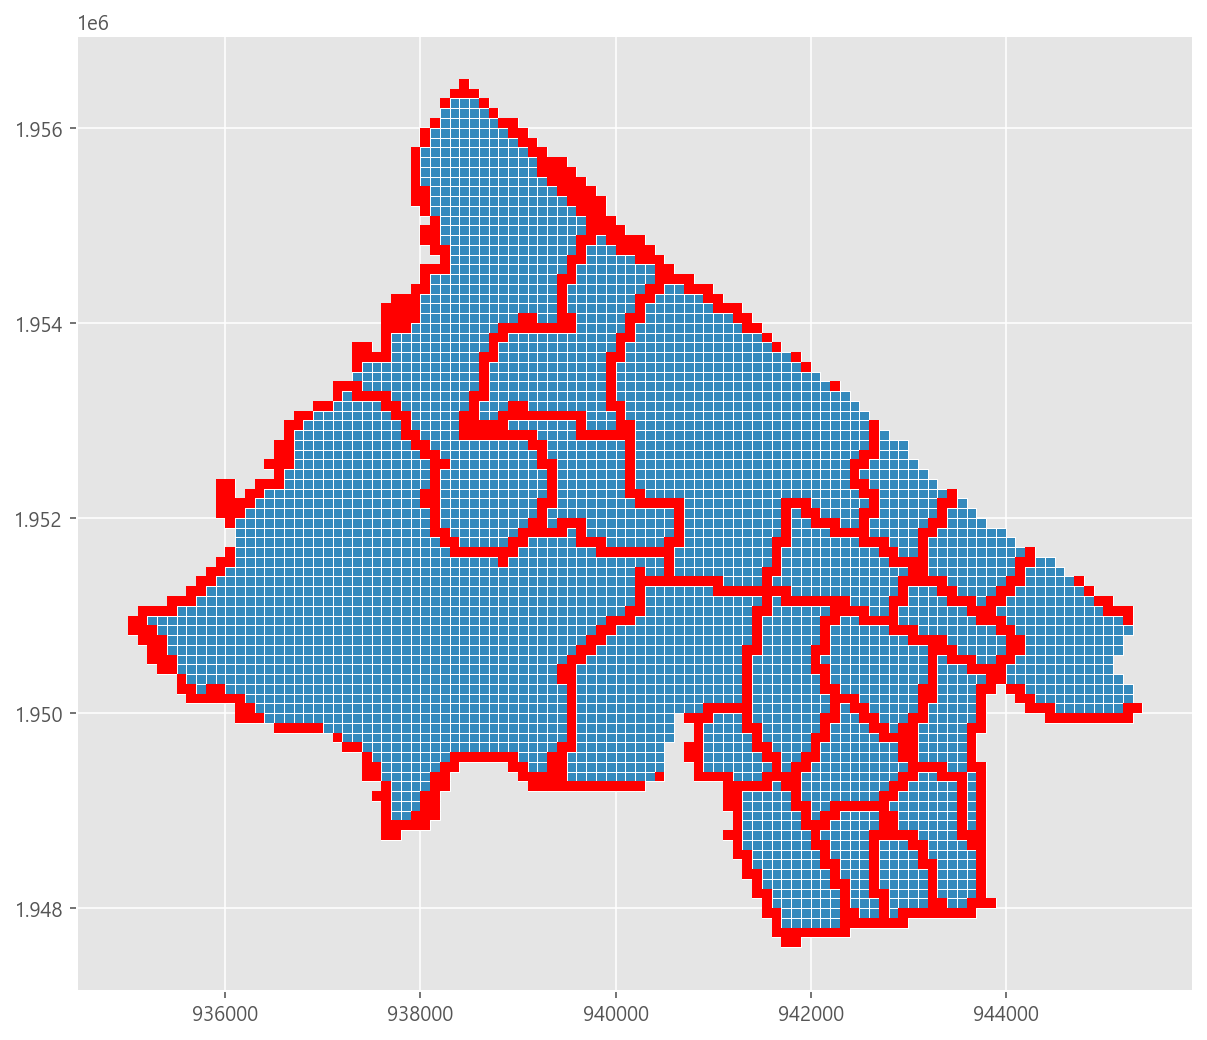

In [60]:
# Geopandas Dataframe으로 plot을 통해서 시각화 하기 
# 붉은 색은 행정동 경계가 불명확한 곳
ax = gangseo_pop_grid.plot(edgecolor='white', figsize=(10, 10))
gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].plot(color = 'red', ax = ax)
plt.show()

In [61]:
# Within으로 구별하지 못한 행정동에 대해서 
# intersection을 통해서 Grid별 가장 많은 면적을 차지하고 있는 행정동을 
# 그 grid의 행정동으로 교체해준다 .
def max_area_hdong(dict_cal):
    print(dict_cal)
    max_area_name=dict_cal[max(dict_cal.keys())]
    print(max_area_name)
    return max_area_name

def grid_intersection(grid):  # polygon 들어가면
    intersection_area = []  # 리스트 지정  이름
    area_hdong_name = [] # 리스트 지정  면적 
    for i in range(len(gangseo_boundary['geometry'])):   # 행정동 구역 돌리기      
        inter_area = grid.intersection(gangseo_boundary['geometry'][i]).area #len만큼 반복하면서 area의 값을 inter_area에 저장
        if inter_area > 0:  # 0보다 크다면 
            area_hdong_name.append(gangseo_boundary['adm_nm'][i]) # 이름 추가하기 
            intersection_area.append(inter_area) # area추가하기 
        else:
            area_hdong_name.append('0')
            intersection_area.append(0)
            
    dict_cal = dict(zip(intersection_area, area_hdong_name)) # dictionary로 묶기  행정동이름 면적
    hdong=max_area_hdong(dict_cal) # max_area_hdong 함수 호출
    return hdong # max_area_hdong을 마친 hdong 최종 return 

# hdong을 구분하지 못한 hdong에 대해서 추출하기
na_index=gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].index
na_gangseo_pop_grid=gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].reset_index(drop=True)
na_gangseo_pop_grid.head()

na_grid_hdong = []
for i in range(len(na_gangseo_pop_grid['geometry'])):    # geometry의 범위만큼 들어감  127, 36
    final_name=grid_intersection(na_gangseo_pop_grid['geometry'][i]) # grid_intersection 함수에 Polygon 들어간다.
    na_grid_hdong.append(final_name)
gangseo_pop_grid.loc[na_index, 'hdong'] = na_grid_hdong

{0: '0', 5975.343240373882: '서울특별시 강서구 방화1동', 4024.6567596261193: '서울특별시 강서구 방화2동'}
서울특별시 강서구 방화1동
{0: '0', 556.1686143801057: '서울특별시 강서구 발산1동', 9443.831385619895: '서울특별시 강서구 우장산동'}
서울특별시 강서구 우장산동
{0: '0', 8548.901800834574: '서울특별시 강서구 화곡3동'}
서울특별시 강서구 화곡3동
{0: '0', 7953.126321511809: '서울특별시 강서구 화곡4동'}
서울특별시 강서구 화곡4동
{0: '0', 8386.943908381145: '서울특별시 강서구 화곡본동', 1613.0560916188556: '서울특별시 강서구 화곡6동'}
서울특별시 강서구 화곡본동
{0: '0', 1193.8387461893847: '서울특별시 강서구 화곡1동'}
서울특별시 강서구 화곡1동
{0: '0', 7493.4530029599055: '서울특별시 강서구 방화1동', 2506.546997040095: '서울특별시 강서구 방화2동'}
서울특별시 강서구 방화1동
{0: '0', 7936.11787727283: '서울특별시 강서구 등촌1동', 2063.88212272717: '서울특별시 강서구 등촌2동'}
서울특별시 강서구 등촌1동
{0: '0', 1004.4788663640296: '서울특별시 강서구 발산1동', 8995.521133635972: '서울특별시 강서구 공항동'}
서울특별시 강서구 공항동
{0: '0', 6657.417692408447: '서울특별시 강서구 화곡8동', 3342.582307591553: '서울특별시 강서구 화곡1동'}
서울특별시 강서구 화곡8동
{0: '0', 1722.584961022244: '서울특별시 강서구 등촌2동', 8277.415038977757: '서울특별시 강서구 화곡4동'}
서울특별시 강서구 화곡4동
{0: '0', 6731.897340388969: '서울특

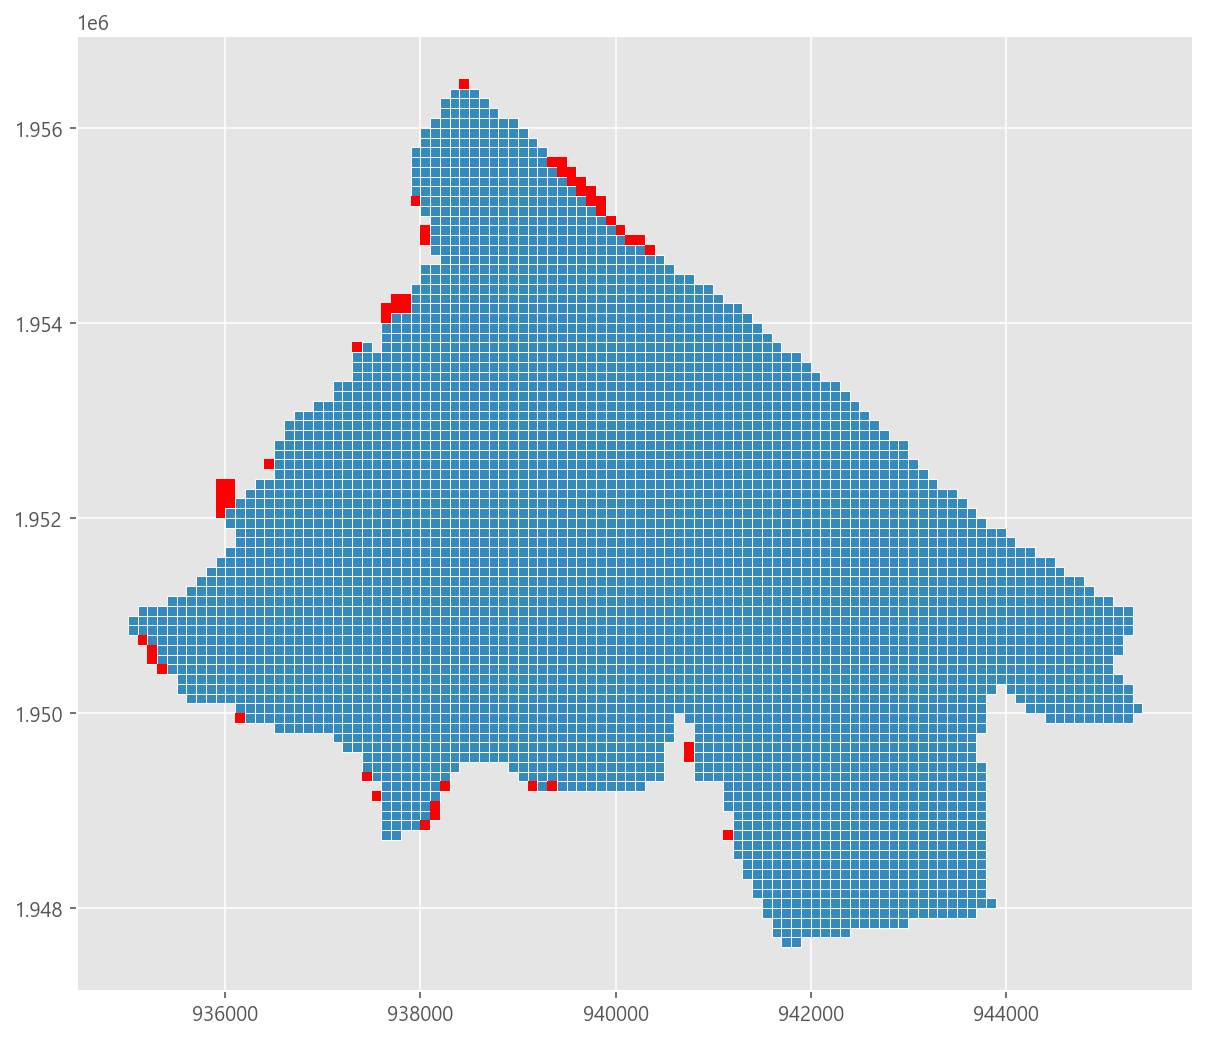

In [62]:
# 2번째 돌렸을때의 결과 
# geopandas dataframe으로 행정동 경계가 불명확한 곳 붉은색으로 표현하기 
ax = gangseo_pop_grid.plot(edgecolor='white', figsize=(10, 10))
gangseo_pop_grid[gangseo_pop_grid['hdong']=='0'].plot(color = 'red', ax = ax)
plt.show()